# EMG Controlled Adaptive Wearable Robotic Exoskeleton for Upper Limb Rehabilitation Using AI

### Check the GPU workig for model training.

In [1]:
import keras
import tensorflow as tf
# Avoid OOM errors by setting GPU Memory Consumption Growth
   
tf.config.list_physical_devices('GPU') 

2025-01-23 18:48:58.733568: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:49:03.246879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737638344.055806    9151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737638344.255323    9151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:49:06.336157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## First Method...

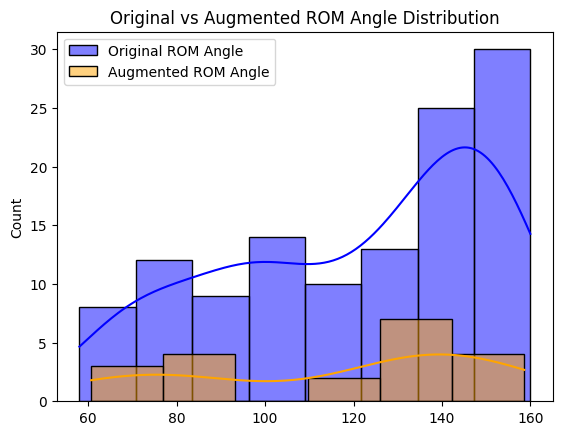

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tsaug import AddNoise, TimeWarp, Drift
import matplotlib.pyplot as plt
import seaborn as sns


# Load and prepare data
file_path = 'New_Data/Final_Dataset.xlsx'
data_01 = pd.read_excel(file_path)
Data = data_01.loc[:, 'ROM_angle':90].values

# Extract Min and Max ROM angle from the original data
rom_angle_min = Data[:, 0].min()
rom_angle_max = Data[:, 0].max()

# Function to constrain ROM angle within original Min and Max range
def constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max):
    augmented_sample[:, 0] = np.clip(augmented_sample[:, 0], rom_angle_min, rom_angle_max)
    return augmented_sample

# Augmentation pipeline
augmenter = (
    TimeWarp(n_speed_change=1, max_speed_ratio=1.2) +
    AddNoise(scale=0.005) +
    Drift(max_drift=0.01, n_drift_points=2)
)

# Generate exactly 20 augmented samples for the entire dataset
augmented_samples = []
for _ in range(20):  # Generate 20 samples
    sampled_rows = Data[np.random.choice(Data.shape[0], size=1, replace=False)]
    augmented_sample = augmenter.augment(sampled_rows)
    augmented_sample = constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max)
    augmented_samples.append(augmented_sample)

# Combine augmented samples into a single array
augmented_samples = np.vstack(augmented_samples)

# Combine original and augmented data
augmented_dataset = np.vstack([Data, augmented_samples])

# Check original and augmented ROM angle distributions
sns.histplot(Data[:, 0], label='Original ROM Angle', kde=True, color='blue')
sns.histplot(augmented_samples[:, 0], label='Augmented ROM Angle', kde=True, color='orange')
plt.legend()
plt.title('Original vs Augmented ROM Angle Distribution')
plt.show()


In [3]:
# Prepare the dataset
X = augmented_dataset[:, 1:]
y = augmented_dataset[:, 0]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Normalize target
y_max, y_min = y.max(), y.min()
y = (y - y_min) / (y_max - y_min)

# Reshape for LSTM input
time_steps = 5
if X_normalized.shape[1] % time_steps != 0:
    n_features = (X_normalized.shape[1] // time_steps) * time_steps
    X_normalized = X_normalized[:, :n_features]
X_reshaped = X_normalized.reshape(X_normalized.shape[0], time_steps, -1)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [7]:
print(f"Train : {X_train.shape[0]}  \nValidation : {X_val.shape[0]} \nTest : {X_test.shape[0]}")

Train : 98  
Validation : 21 
Test : 22


| Layer                  | Parameters               | Additional Details                     |
|------------------------|--------------------------|----------------------------------------|
| **Conv1D**            | 32 filters, kernel size=3 | Activation: ReLU, Input shape: (X_reshaped.shape[1], X_reshaped.shape[2]) |
| **MaxPooling1D**       | Pool size=2              | -                                      |
| **LSTM**               | 64 units                | Return sequences: True                 |
| **Dropout**            | Dropout rate=0.3         | -                                      |
| **LSTM**               | 32 units                | Return sequences: False                |
| **Dropout**            | Dropout rate=0.2         | -                                      |
| **Dense**              | 1 unit                  | Regularisation: l2(0.001)              |


In [8]:
# Model definition
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l2(0.001))
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=['mae','mse', RootMeanSquaredError()]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/150


E0000 00:00:1737638608.034267    9285 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-01-23 18:53:28.035161: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops_impl.h:1204 : INVALID_ARGUMENT: No DNN in stream executor.


InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/conv1d_2_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_9151/975740656.py", line 24, in <module>

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/models/functional.py", line 632, in call

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/layers/convolutional/conv1d.py", line 151, in call

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1183, in conv

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 301, in conv

  File "/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 274, in _conv

No DNN in stream executor.
	 [[{{node sequential_2_1/conv1d_2_1/convolution}}]] [Op:__inference_multi_step_on_iterator_10128]

<built-in function ctime>


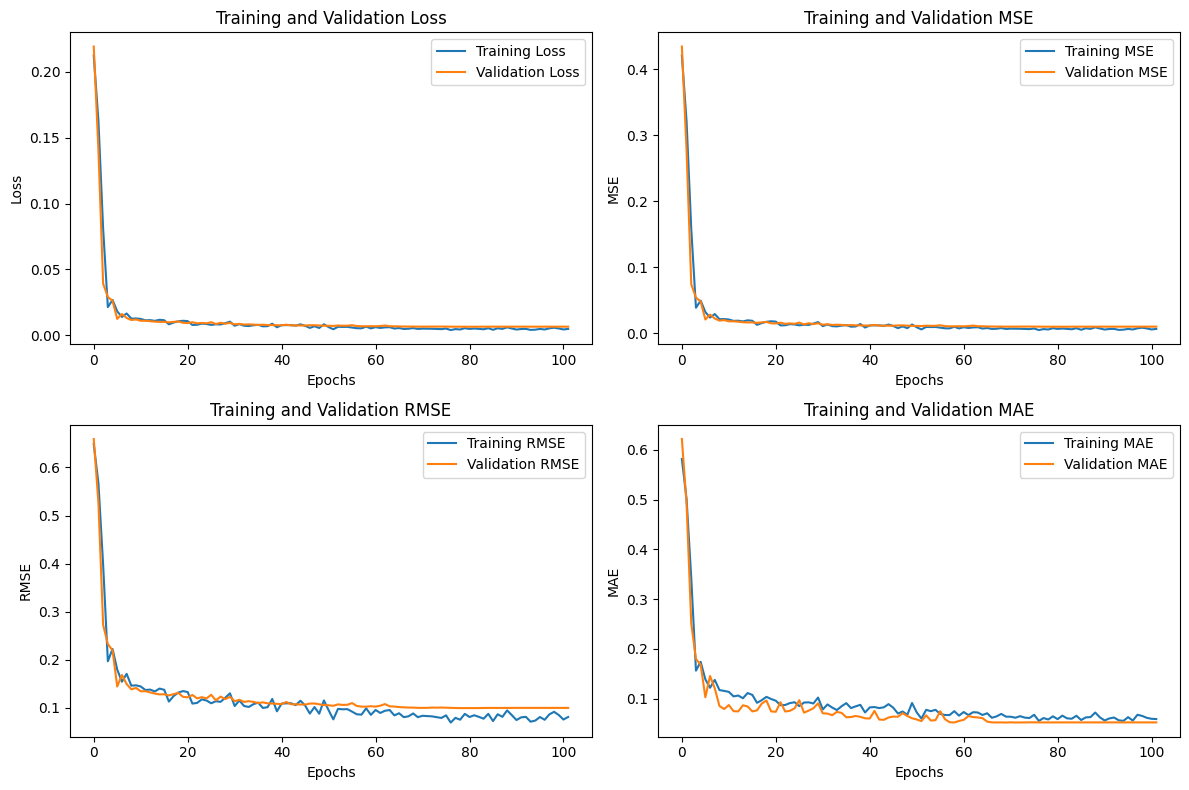


Final Metrics:
R2 Score: 96.40%
MAE: 4.20805
MSE: 30.86698
RMSE: 5.55581
Test Accuracy (based on MAPE): 95.62%


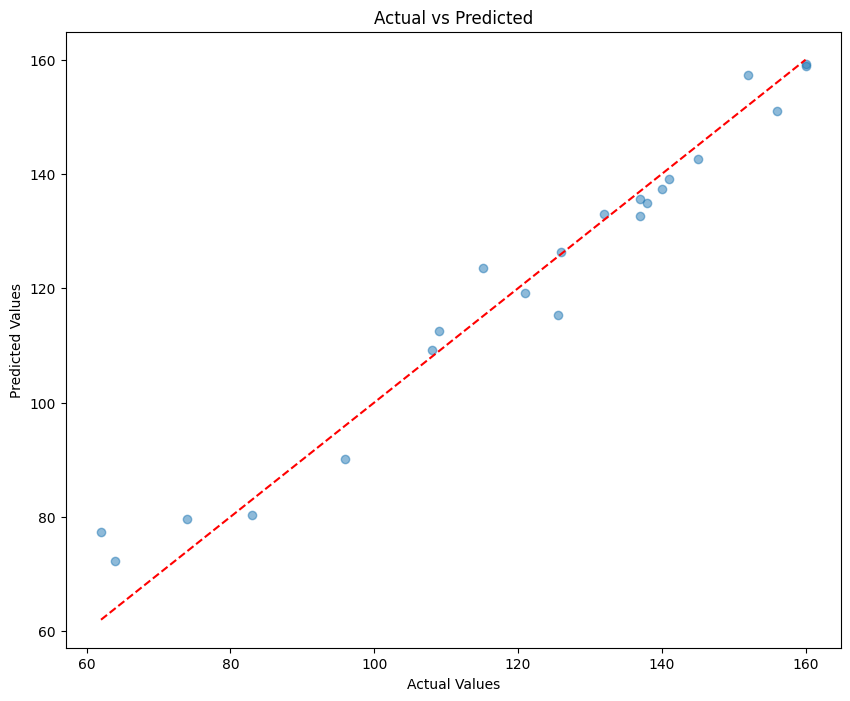

In [39]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
predictions = model.predict(X_test)
inv_pred = predictions * (y_max - y_min) + y_min
inv_y_test = y_test * (y_max - y_min) + y_min

# Metrics
mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
test_accuracy = 100 - mape  # Higher accuracy corresponds to lower error
r2 = r2_score(inv_y_test, inv_pred)
mae = mean_absolute_error(inv_y_test, inv_pred)
mse = mean_squared_error(inv_y_test, inv_pred)
rmse = np.sqrt(mse)

# Results
print("\nFinal Metrics:")
print(f'R2 Score: {r2 * 100:.2f}%')
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(inv_y_test, inv_pred, alpha=0.5)
plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Save the model
# model.save('Saved_Models/cnn_lstm_emg_model.h5')


## Updated 2nd method...

| Layer                  | Parameters               | Additional Details                     |
|------------------------|--------------------------|----------------------------------------|
| **Conv1D**            | 64 filters, kernel size=3 | Activation: ReLU, Input shape: (X_reshaped.shape[1], X_reshaped.shape[2]) |
| **BatchNormalization** |                          | -                                      |
| **MaxPooling1D**       | Pool size=2              | -                                      |
| **LSTM**               | 64 units                | Return sequences: True                 |
| **Dropout**            | Dropout rate=0.3         | -                                      |
| **LSTM**               | 32 units                | Return sequences: False                |
| **Dropout**            | Dropout rate=0.2         | -                                      |
| **Dense**              | 32 units                | Activation: ReLU                       |
| **BatchNormalization** |                          | -                                      |
| **Dense**              | 16 units                | Activation: ReLU                       |
| **Dense**              | 1 unit                  | Regularisation: l2(0.001)              |


Epoch 1/150
7/7 [==============================] - 4s 180ms/step - loss: 0.3039 - mae: 0.6420 - root_mean_squared_error: 0.8296 - val_loss: 0.2379 - val_mae: 0.6460 - val_root_mean_squared_error: 0.6862 - lr: 0.0010
Epoch 2/150
7/7 [==============================] - 0s 16ms/step - loss: 0.1521 - mae: 0.4568 - root_mean_squared_error: 0.5487 - val_loss: 0.2055 - val_mae: 0.5940 - val_root_mean_squared_error: 0.6372 - lr: 0.0010
Epoch 3/150
7/7 [==============================] - 0s 16ms/step - loss: 0.1050 - mae: 0.3877 - root_mean_squared_error: 0.4531 - val_loss: 0.1767 - val_mae: 0.5453 - val_root_mean_squared_error: 0.5904 - lr: 0.0010
Epoch 4/150
7/7 [==============================] - 0s 16ms/step - loss: 0.0809 - mae: 0.3121 - root_mean_squared_error: 0.4009 - val_loss: 0.1558 - val_mae: 0.5122 - val_root_mean_squared_error: 0.5537 - lr: 0.0010
Epoch 5/150
7/7 [==============================] - 0s 16ms/step - loss: 0.0527 - mae: 0.2463 - root_mean_squared_error: 0.3171 - val_loss: 

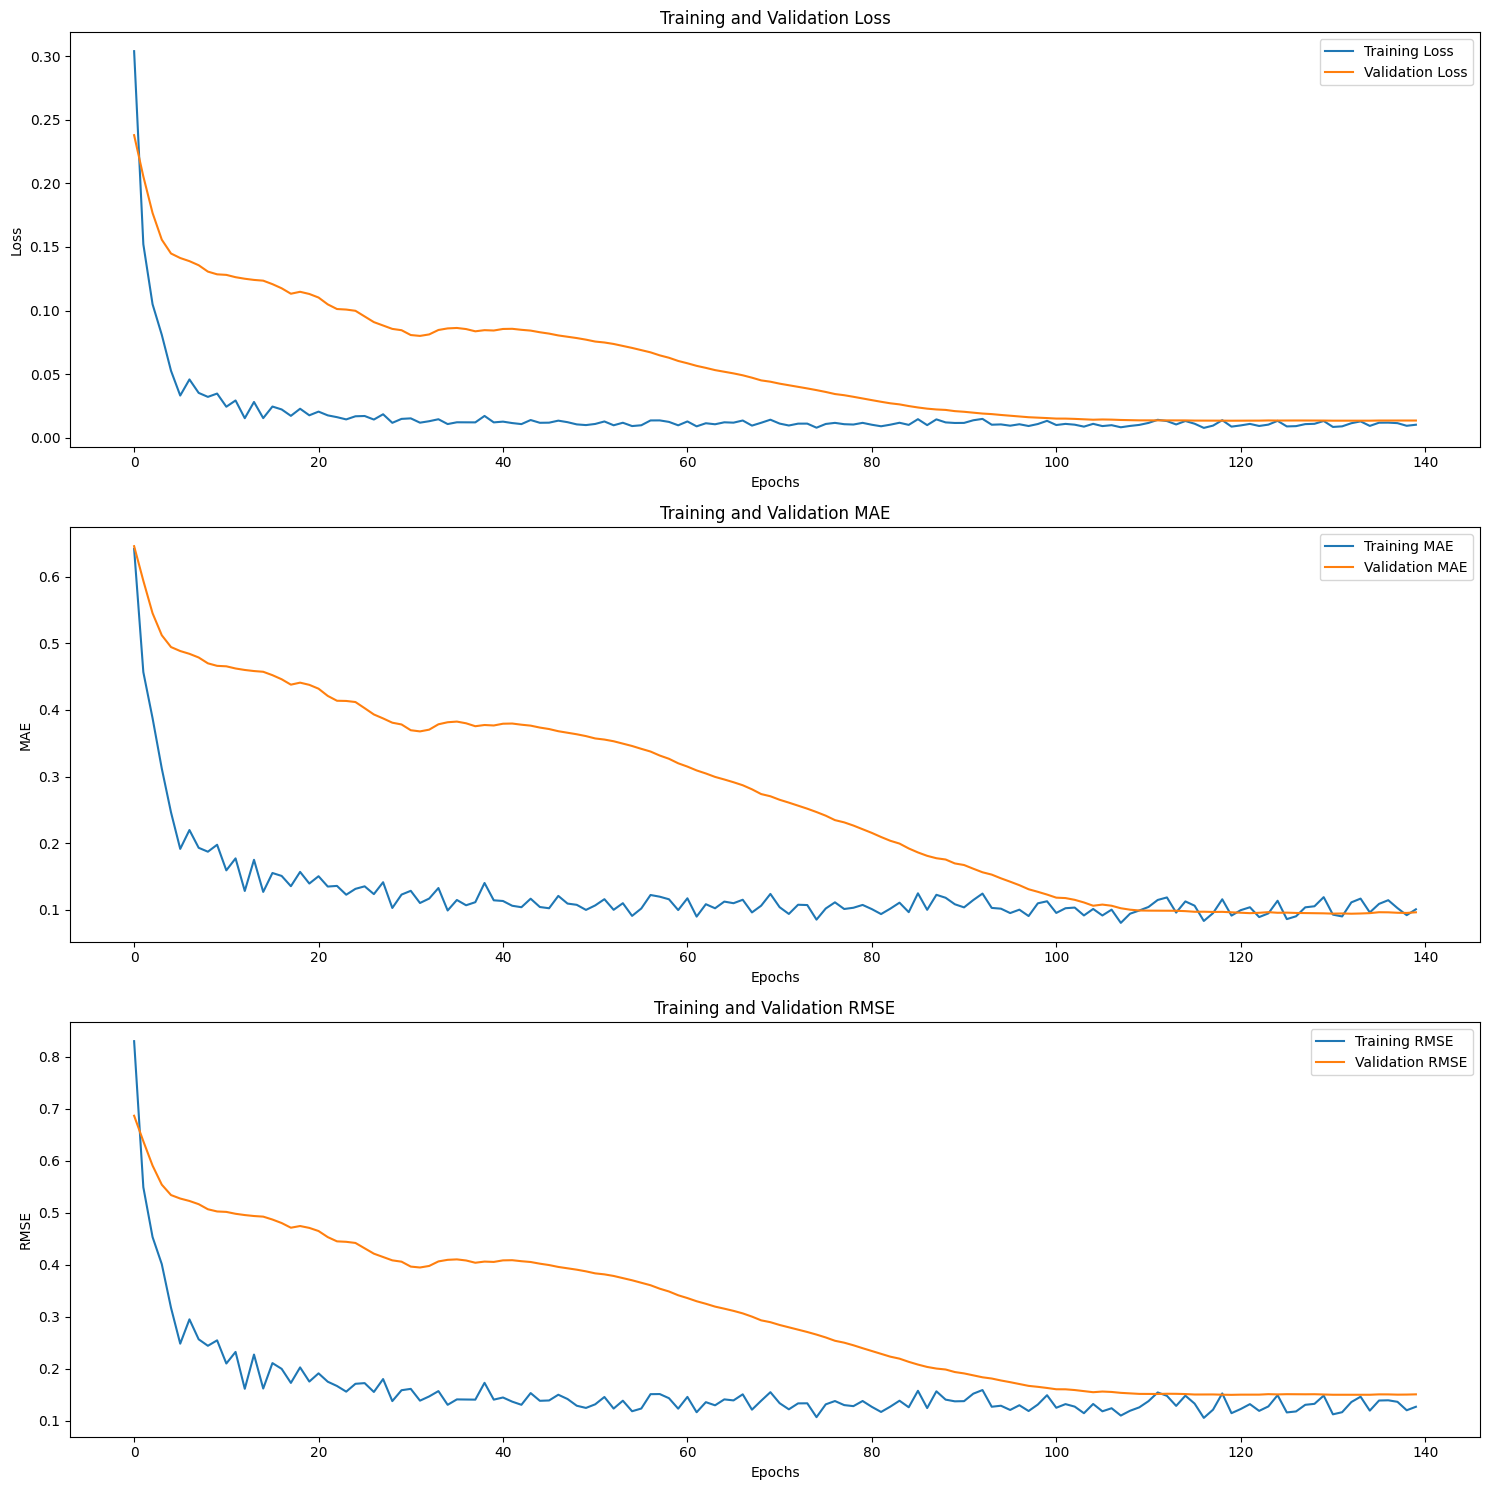


Final Metrics:
R2 Score: 85.51%
MAE: 8.71712
MSE: 124.30093
RMSE: 11.14903
Test Accuracy (based on MAPE): 91.97%


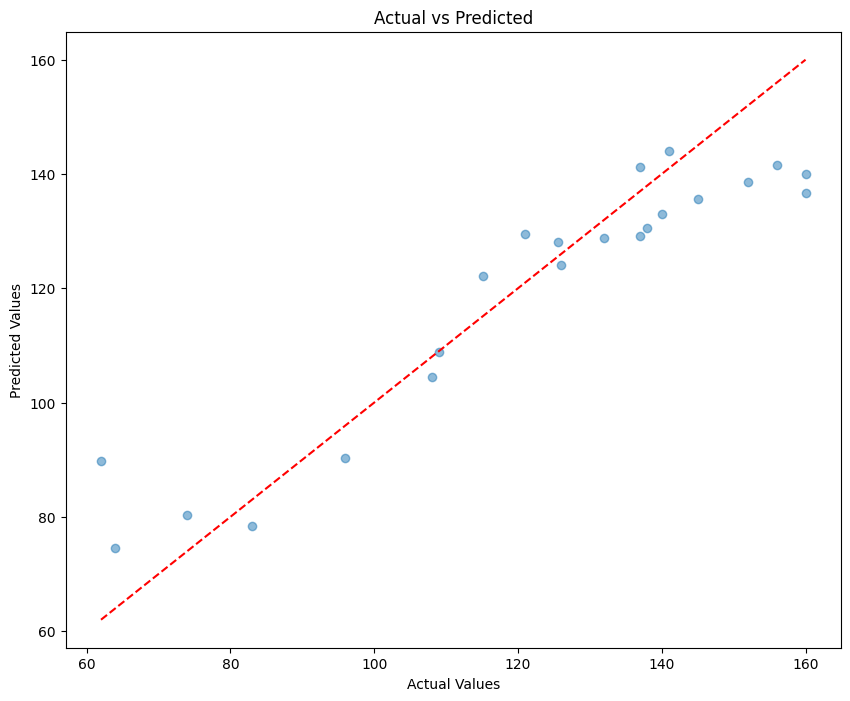

In [7]:
# Model definition

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, kernel_regularizer=l2(0.001))
]) 



# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=['mae', RootMeanSquaredError()]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot Training and Validation Metrics
plt.figure(figsize=(15, 15))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(3, 1, 3)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
predictions = model.predict(X_test)
inv_pred = predictions * (y_max - y_min) + y_min
inv_y_test = y_test * (y_max - y_min) + y_min

# Metrics
mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
test_accuracy = 100 - mape  # Higher accuracy corresponds to lower error
r2 = r2_score(inv_y_test, inv_pred)
mae = mean_absolute_error(inv_y_test, inv_pred)
mse = mean_squared_error(inv_y_test, inv_pred)
rmse = np.sqrt(mse)

# Results
print("\nFinal Metrics:")
print(f'R2 Score: {r2 * 100:.2f}%')
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(inv_y_test, inv_pred, alpha=0.5)
plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Save the model

# GRU ...


In [ ]:
# Model definition
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l2(0.001))
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=['mae','mse', RootMeanSquaredError()]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


In [ ]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
predictions = model.predict(X_test)
inv_pred = predictions * (y_max - y_min) + y_min
inv_y_test = y_test * (y_max - y_min) + y_min

# Metrics
mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
test_accuracy = 100 - mape  # Higher accuracy corresponds to lower error
r2 = r2_score(inv_y_test, inv_pred)
mae = mean_absolute_error(inv_y_test, inv_pred)
mse = mean_squared_error(inv_y_test, inv_pred)
rmse = np.sqrt(mse)

# Results
print("\nFinal Metrics:")
print(f'R2 Score: {r2 * 100:.2f}%')
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(inv_y_test, inv_pred, alpha=0.5)
plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Save the model
# model.save('Saved_Models/cnn_lstm_emg_model.h5')